MATH80629 automne 2020
=======

Tutoriel: Introduction pratique à l'apprentissage automatique (avec le solutionnaire)
=============

Ce tutoriel se veut une courte introduction à l'utilisation pratique de l'apprentissage automatique (machine learning).

Nous supposons que l'étudiant a déjà une compréhension des fondamentaux du domaine et nous nous travaillerons les concepts d'apprentissage supervisé avec les libraires python `scikit-learn`, `pandas` et `numpy`.

Ce document propose les trois étapes suivantes: 
1. chargement et prétraitement des données, 
2. estimations de différents modèles sur quelques versions du jeu de données,
3. comparaison des résultats.

Ce tutoriel ne se veut pas exhaustif. Lorsque les notions abordées requièrent plus de précisions, nous proposons des compléments d'information externes. De plus, il y a quelques références plus générales sur les librairies à la fin du tutoriel.  

### Auteur: 
- Laurent Charlin <lcharlin@gmail.com>

### Table des matières

- [Section 0. Introduction](#introduction)
- [Section 1. Prétraitement des données](#pre-processing)
- [Section 2. Modélisation](#modelling)
- [Section 3. Conclusions](#concluding-remarks)

<a id='introduction'></a>
### Section 0. Introduction

Plutôt que d'utiliser une tâche bidon ou un jeu de données synthétiques, nous utiliserons l'exemple d'un système de recommandation pour explorer les bases pratiques de l'apprentissage automatique. Notre tâche sera donc de recommander des films à des utilisateurs (vous pouvez imaginer que vous êtes ingénieur chez Netflix). Nous modéliserons les préférences pour les films d'utilisateurs venant d'un jeu de données publique (Movielens 1M). Notre modèle apprendra à prédire les notes (*ratings*) des utilisateurs pour des films à partir de données sociodémographiques des utilisateurs ainsi que des *tags* des films.

Formellement, nous nous intéressons donc à apprendre les paramètres de la fonction:  

$$ r_{um} = f_\theta(x_u, x_m)$$ 
où 
- $u$ indexe les utilisateurs 
- $m$ indexe les items
- $r_{um}$ est la note (rating) de l'utilisateur u pour le film m -- c'est la variable dépendante
- $f_\theta$ est le modèle paramétré par $\theta$. Par exemple, un modèle de régression linéaire avec des coefficients $\theta$
- $x_u$ sont les attributs de l'utilisateur u (p.ex., l'âge et l'emploi de l'utilisateur)
- $x_m$ sont les attributs du film m (p.ex., les *tags* données au film)

La fonction $f$ peut être modélisée de plusieurs façons. Aujourd'hui, nous prendrons pour hypothèse que la tâche de recommandation en est une de prédiction de notes et donc c'est un problème de régression. Nous comparerons plusieurs modèles linéaires (régression linéaire) et non-linéaires (comme un réseau de neurones).


### Terminologie en Apprentissage Automatique 

Rappelons nous que nous utilisons une définition de l'apprentissage automatique ayant trois concepts:

1. Tâche / Task (T)
2. Expérience / Experience (E)
3. Mesure de performance / Performance measure (P).

(une description complète de ces trois concepts est donnée au [Ch. 5 du livre Deep Learning](https://www.deeplearningbook.org/contents/ml.html))

L'intuition c'est que la tâche (T) c'est le problème que l'on veut résoudre (p.ex., classification, régression, détection d'anomalies), l'expérience (E) c'est le type de données disponibles et comment le modèle y accède (p.ex., avec ou sans étiquettes, en flux ou d'un coup). Finalement la performance (P) c'est la qualité du modèle finale en fonction d'une mesure précise. Par exemple on utilise souvent l'erreur au carré (*squared error*) ou la précision (*accuracy*) du modèle. 

N'oubliez pas que la terminologie ci-haut ne définit pas directement le modèle à utiliser, elle ne définit pas non plus la procédure pour estimer les paramètres.

Notre problème de prédictions de notes (*ratings*) se décompose comme ceci: 
- Tâche: Notre tâche est de prédire les notes des utilisateurs pour les films. Nous pourrions la modéliser de différentes manières (plus de détails à la semaine 11), pour l'instant nous imaginons que c'est un problème de régression. 
- Expérience: L'expérience en est une d'apprentissage supervisé puisque nous essayons de prédire la note (la variable dépendante) à partir d'un ensemble de variables indépendantes.
- La mesure de performance: Comme c'est souvent le cas en régression linéaire, nous utiliserons l'erreur moyenne au carrée.

### Prétraitement des données

Pour l'apprentissage supervisé, comme c'est souvent le cas, nous représenterons les données en utilisant deux matrices $X$ et $Y$. La première, $X$, contient les attributs (*features*). C'est une matrice de taille $n \times p$, avec $n$ le nombre d'exemples et $p$ la dimensionnalité de chaque exemple (en d'autres mots, le nombre d'attributs de chaque exemple). 

$$X = \begin{bmatrix} 
x_{11} & x_{12} & \ldots & x_{1p} \\
\vdots & \vdots       &  \ddots      & \vdots \\ 
x_{n1} & x_{12} & \ldots & x_{np} \\
\end{bmatrix}
$$ 

$Y$, est un vecteur (colonne) de taille $n$ qui content les étiquettes (ici ce sont les notes des films). $Y_1$ correspond aux notes de $X_1$.

$$
Y = \begin{bmatrix} 
r_1 \\
r_2 \\
\vdots \\ 
r_n
\end{bmatrix}$$

Nous différencierons les ensembles d'entraînement (`train`) des ensembles de test (`test`), p.ex.,, en utilisant cette notation $X_\text{train}$ et $X_\text{test}$. Idem pour les étiquettes $Y_\text{train}$ et $Y_\text{test}$.

## On commence

Après cette courte introduction, nous pouvons maintenant nous pencher sur le problème et le code pour le résoudre.

In [1]:
# Commencons par télécharger le code et les données (Ces étapes sont essentielles pour la plateforme colab)
!rm -rf 80-629/
!git clone https://github.com/lcharlin/80-629/

Cloning into '80-629'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 222 (delta 95), reused 126 (delta 51), pack-reused 52
Receiving objects: 100% (222/222), 74.20 MiB | 4.48 MiB/s, done.
Resolving deltas: 100% (109/109), done.


Nous importerons tout d'abord différentes libraires dont nous aurons besoin: 
- `reduce` une fonction qui sera pratique pour traiter des données de manière itérative
- `os` une librairie standard pour, notamment, interagir avec le système de fichiers (p.ex., pour ouvrir un fichier)
- `re` une librairie pour les expressions régulières
- `sys` une librairie pour obtenir des informations du système 
- `time` une librairie pour évaluer le temps de calcul de certaines opérations (p.ex., estimer les paramètres d'un modèle)



- `matplotlib` pour tracer des graphiques
- `numpy` pour des fonctions d'algèbre linéaire
- `pandas` pour manipuler les données
- `sklearn` (scikit-learn) pour des modèles d'apprentissage automatique ainsi que des fonctions reliées à la pratique de l'apprentissage automatique

In [2]:
from functools import reduce
import os
import re 
import time

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import neural_network

import sys
sys.path += ['80-629/week4-PracticalSession/']
from local_utils import DrawNN

<a id='pre-processing'></a>
# Section 1: Prétraitement des données

Dans les prochaines cellules, nous chargerons des données à partir d'un fichier csv et les prétraiterons. 

Bien que ce ne soit pas de l'apprentissage automatique, nos modèles auront toujours besoin de données. Il est donc utile de connaître quelques manières de traiter les données. (Notez qu'en pratique, il est souvent plus long de prétraiter les données que d'estimer les modèles.) 

**Je vous suggère de lire cette section, mais de plutôt vous attarder sur les sections subséquentes. Si vous finissez le tutoriel avant la fin de la séance, vous pourrez vous attarder sur cette section.** 

#### Quelques précisions

Nous utiliserons le jeu de [données movielens](https://grouplens.org/datasets/movielens/) qui est disponible publiquement. Le groupe de recherche qui a récolté movielens, a récolté plusieurs jeux de données depuis 20 ans. Nous utiliserons surtout le jeu [ML-1M](https://grouplens.org/datasets/movielens/1m/) qui contient un million de notes. Nous utiliserons en plus les *tags* venant du [jeu ML-20M](https://grouplens.org/datasets/movielens/20m/) (celui-là contient 20M de notes). 

A part avoir téléchargé le jeu de données, je ne l'ai pas prétraité ou modifié.

In [3]:
ROOT_DIR='80-629/'
DATA_DIR=os.path.join(ROOT_DIR, 'dat/ml-1m/') # C'est ici que se trouve les notes 
DATA_DIR_20ML=os.path.join(ROOT_DIR, 'dat/ml-20m/') # C'est ici que se trouve les *tags*

#### Charger les noms et types des films

Nous commençons par charger en mémoire les données qui décrivent les films du jeu ML-1M à partir du fichier `movies.data`. Chaque ligne dans ce fichier contient les informations suivantes `MovieID::Name::Genres`. 

Après avoir chargé les données dans une structure `dataFrame` de pandas, cette structure (movies_pd) contiendra les noms des films (`mName`), un identificateur unique (`mid`) et que la catégorie du film (`mGenres`). 

In [4]:
movies_pd = pd.read_csv(os.path.join(DATA_DIR, 'movies.dat'), 
                        sep='::', 
                        names=['mid', 'mName', 'mGenres'], engine='python')

In [5]:
print(f'Ce jeu de données contient {movies_pd.shape[0]} films.')

Ce jeu de données contient 3883 films.


In [6]:
display(movies_pd.head())

,mid,mName,mGenres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


Grace à pandas nous pouvons aussi chercher un film par son identificateur unique `mid` ainsi que par son nom:

In [7]:
mid = 10  # cherchons le film avec l'identificateur 10
display(movies_pd[movies_pd.mid==mid])

name = 'Machine' # cherchons un film contenant ce mot dans son titre
display(movies_pd[movies_pd.mName.str.contains(name, 
                                               regex=False, case=False)])

,mid,mName,mGenres
9,10,GoldenEye (1995),Action|Adventure|Thriller


,mid,mName,mGenres
1409,1433,"Machine, The (1994)",Comedy|Horror


#### Charger les notes

En utilisant la même fonction que plus haut, nous pouvons aussi charger les notes des utilisateurs pour les films. Elles sont dans ce format `UserID::MovieID::Rating::Timestamp` et nous nommerons la colonne avec l'identifiant de l'utilisateur `uid`, la colonne avec l'identifiant du film `mid`, la note avec `rating`, et le moment où la note a été ajoutée au système avec `timestamp`.

In [8]:
ratings_pd = pd.read_csv(os.path.join(DATA_DIR, 'ratings.dat'), 
                         sep='::',
                         names=['uid', 'mid', 'rating', 'timestamp'],
                         parse_dates=['timestamp'],
                         infer_datetime_format=True,
                         engine='python')

display(ratings_pd.head())

,uid,mid,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [9]:
print(f"""Ce jeu de données contient {ratings_pd.shape[0]} notes, 
      venant de {ratings_pd.uid.nunique()} utilisateurs, 
      et de {ratings_pd.mid.nunique()} items (films).""")

Ce jeu de données contient 1000209 notes, 
      venant de 6040 utilisateurs, 
      et de 3706 items (films).


#### Charger les données sociodémographiques des utilisateurs

Le fichier est aussi un csv en format `UserID::Gender::Age::Occupation::Zip-code`, que nous chargerons dans un `dataFrame` ayant les colonnes `uid,gender,age,occupation,zip`. 



In [10]:
users_pd = pd.read_csv(os.path.join(DATA_DIR, 'users.dat'),
                       sep='::',
                       names=['uid', 'gender', 'age', 'occupation', 'zip'],
                       engine="python")

display(users_pd.head())

,uid,gender,age,occupation,zip
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [11]:
print(f'Ce jeu de données contient {users_pd.shape[0]} utilisateurs.')

Ce jeu de données contient 6040 utilisateurs.


Vous avez peut-être remarqué que chaque code postal (zip code) est une suite de 5 chiffres. Puisqu'il y en a beaucoup, nous préférons les tronquer et en garder que les deux premiers chiffres (donc 27392 -> 27). La raison est simple, les codes postaux sont des variables catégorielles et nous n'avons que 6K utilisateurs et >3.4K codes postaux uniques, il est donc improbable que les coefficients qui y seront associés soient très précis.

In [12]:
print(f'Nous débutons avec {users_pd.zip.nunique()} code postaux (zip codes) uniques.')
users_pd['zip'] = users_pd['zip'].apply(lambda x: x[:2])
display(users_pd['zip'].head())
print(f'En ne conservant que les deux premiers chiffres de chaque code, nous réduisons le nombre de code uniques à {users_pd.zip.nunique()}.')

Nous débutons avec 3439 code postaux (zip codes) uniques.


0    48
1    70
2    55
3    02
4    55
Name: zip, dtype: object

En ne conservant que les deux premiers chiffres de chaque code, nous réduisons le nombre de code uniques à 100.


Nous devons aussi charger les *tags* associées aux films (nous utiliserons les *tags* du jeu de données ml-20M). Les utilisateurs associent les *tags* aux films. Chaque paire film-tag est aussi associée à un degré d'affinité (il dépend du nombre d'utilisateurs ayant *tagger* le film avec un *tag*). 

Encore une fois, nous chargerons les données csv `movieId,tagId,relevance` dans une structure `dataFrame` ayant les colonnes `mid,tid,relevance`. 

In [13]:
# chargement des tags provenant du jeu ML-20m
tags_scores = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-scores.csv.gz'), 
                          skiprows=1, 
                          names=['mid', 'tid', 'relevance'])
display(tags_scores.head(10))

,mid,tid,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675
5,1,6,0.21700
6,1,7,0.06700
7,1,8,0.26275
8,1,9,0.26200
9,1,10,0.03200


In [14]:
print(f'Les données contiennent {tags_scores.tid.nunique()} tags uniques.')
print(f"L'étendue des affinitées est de {tags_scores.relevance.min()}--{tags_scores.relevance.max()}.")
display(tags_scores.relevance.describe())

Les données contiennent 1128 tags uniques.
L'étendue des affinitées est de 0.00024999999999997247--1.0.


count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

Notons que les affinitées sont donc (grosso modo) comprises entre des valeurs de 0 et de 1 avec une moyenne de 0.12.

#### Charger les noms des tags

Ces données pourront être utiles pour mieux comprendre et explorer nos résultats. 

In [15]:
tags_names = pd.read_csv(os.path.join(DATA_DIR_20ML, 'genome-tags.csv'), skiprows=1, names=['tid', 'tName'])
display(tags_names.head(10))

,tid,tName
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s
5,6,1950s
6,7,1960s
7,8,1970s
8,9,1980s
9,10,19th century


Puisque les tags viennent d'un autre ensemble de données qui est aussi plus récent (ml-20M), nous n'avons qu'à garder les tags qui correspondent à des films dans notre ensemble (ml-1M). Heureusement, puisque les deux jeux de données viennent du même fournisseur (movielens), les identifiants des films (`mid`) sont les mêmes dans les deux jeux de données (p.ex., nous n'avons donc pas besoin d'apparier les films selon leur titre, qui sont en général plus bruités).

(Notez: Pandas vous donne accès à un ensemble d'opérations comparables aux fonctions de SQL pour les bases de données relationnelles.)

In [16]:
tags_scores = tags_scores.loc[tags_scores['mid'].isin(ratings_pd['mid'].unique())]
print(tags_scores.mid.nunique())

3470


Nous avons perdu quelques films (qui ne contenaient donc pas de *tags*), mais ce n'est pas très grave pour aujourd'hui.

Ensuite, nous conserverons que les affinités les plus hautes pour chaque film. En d'autres mots, nous imaginons donc que la présence d'un *tag* est plus importante que son absence. En plus, cette opération nous permet de réduire le nombre de *tags* par film.

In [17]:
# Nous conversons que les pairs film-tag ayant une affinité supérieure à 0.9
print('unique tags:', tags_scores['tid'].nunique())
tags_scores_high = tags_scores.loc[tags_scores['relevance'] > 0.9]
print('unique tags w. high relevance:', tags_scores_high['tid'].nunique())

unique tags: 1128
unique tags w. high relevance: 968


#### Explorons les *tags*

Essayons de comprendre comment les utilisateurs du système ont *tagger* les films. Avant tout, il nous sera pratique d'avoir une structure de type `dataFrame` qui contiendra les noms de tags, les noms de films ainsi que les affinités.  (pour l'instant, ces données sont dans trois différentes structures). 

En pandas, la fonction `merge` est utile pour joindre deux `dataFrames` en utilisant une clé unique. (C'est une opération inspirée d'une jointure interne (*inner join*) en SQL.)

In [18]:
tags_high_names_movies = pd.merge(tags_scores_high, tags_names, how='inner', on='tid')
tags_high_names_movies = pd.merge(tags_high_names_movies, movies_pd, how='inner', on='mid')
display(tags_high_names_movies.head())

,mid,tid,relevance,tName,mName,mGenres
0,1,63,0.93325,animated,Toy Story (1995),Animation|Children's|Comedy
1,1,64,0.98575,animation,Toy Story (1995),Animation|Children's|Comedy
2,1,186,0.95650,cartoon,Toy Story (1995),Animation|Children's|Comedy
3,1,203,0.92625,childhood,Toy Story (1995),Animation|Children's|Comedy
4,1,204,0.96425,children,Toy Story (1995),Animation|Children's|Comedy


Un peu comme plus haut, nous pouvons maintenant trouver les films ayant la plus haute affinité pour une certaine *tag*:

In [19]:
tag = 'scary' # Le nom (partiel ou complet) du tag que nous chercherons
display(tags_high_names_movies[
    tags_high_names_movies.tName.str.contains(tag, 
                                               regex=False, case=False)].sort_values(by=['relevance'],
                                                                                    ascending=False))

,mid,tid,relevance,tName,mName,mGenres
13151,2710,882,0.96700,scary,"Blair Witch Project, The (1999)",Horror
14005,1342,882,0.96625,scary,Candyman (1992),Horror
9205,1347,882,0.96550,scary,"Nightmare on Elm Street, A (1984)",Horror
14658,3892,882,0.96475,scary,Anatomy (Anatomie) (2000),Horror
3187,1997,882,0.96200,scary,"Exorcist, The (1973)",Horror
14021,2550,882,0.95625,scary,"Haunting, The (1963)",Horror|Thriller
11492,1350,882,0.94675,scary,"Omen, The (1976)",Horror
11546,2841,882,0.94650,scary,Stir of Echoes (1999),Thriller
9340,1974,882,0.94625,scary,Friday the 13th (1980),Horror
2976,1387,882,0.94250,scary,Jaws (1975),Action|Horror


Cette prochaine étape nous permettra d'explorer de manière plus complète les *tags* en plus de fournir un prétraitement qui sera utile pour estimer les modèles à partir de ces données.

Dans le jeu de données actuel, chaque pair film-tag est dans un exemple différent (c.-à-d. dans une différente rangée du `dataFrame`). Il sera essentiel pour les modèles que tous les attributs d'un exemple soient sur une même ligne. Nous voulons donc construire une matrice $X$ où chaque exemple aura sa propre ligne. 

Pour ce faire, nous allons réencoder les `tid` en utilisant un encodage 1-de-K aussi connu comme l'ajout de variables *dummy*. Il est essentiel de comprendre que les données catégorielles (par exemple, « chien / chat ») ne sont pas des variables numériques comme les autres **puisqu'elles n'ont pas d'ordre**. Dans notre jeu de données, les tags ont une valeur numérique (p.ex., la *tag* `scary` a la valeur `882`), mais on ne peut pas comparer les *tags* à l'aide de cette valeur (p.ex., on ne peut pas dire que la *tag* `882` est plus grande que la *tag* `880` ou plus petite que la *tag* `900`). L'encodage 1-de-K traite ce cas en encodant chaque *tag* dans un vecteur binaire, de taille $K$ où la seule valeur non nulle (en général avec une valeur de 1) correspond à l'index du tag. Dans le cas présent, nous avons $K=968$ *tags*, et la *tag* `scary` serait encodée dans un vecteur de `0` ayant une seul `1` à la position `882`. 

Ci-bas vous verrez qu'après cette transformation (1-de-K), nos données ont maintenant 971 colonnes: 968 pour les tags, une pour le `mid`, une pour la note (`relevance`) et une dernière pour l'index de pandas.

In [20]:
#print(tags_scores_high.shape)
tags_scores_high_dum = pd.get_dummies(tags_scores_high, columns=['tid'])
tags_scores_high_dum = tags_scores_high_dum.reset_index()
#print(tags_scores_high_dum.shape)
display(tags_scores_high_dum.head())
tags_per_movie = tags_scores_high_dum.groupby("mid").sum()

,index,mid,relevance,tid_1,tid_2,tid_3,tid_5,tid_6,tid_7,tid_9,...,tid_1119,tid_1120,tid_1121,tid_1122,tid_1123,tid_1124,tid_1125,tid_1126,tid_1127,tid_1128
0,62,1,0.93325,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,1,0.98575,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,185,1,0.95650,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,202,1,0.92625,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,203,1,0.96425,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Grâce à ces données, nous pouvons aisément explorer la distribution du nombre de films par tag (et inversement du nombre de tags par film, voir dessous).

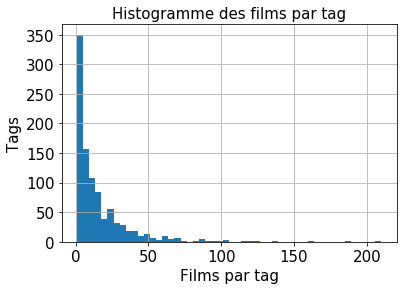

In [21]:
th = tags_scores_high.groupby("tid").count()
hists = th.hist(bins=50, column="mid", xlabelsize=15, ylabelsize=15)[0][0]
hists.set_ylabel("Tags", size=15)
hists.set_xlabel("Films par tag", size=15)
hists.set_title("Histogramme des films par tag", size=15);

Dans cet histogramme chaque barre verticale correspond au nombre de *tags* (axe des y) pour un nombre de films (axe des x). Par exemple, il y a 350 *tags* n'ont été utilisé qu'une poignée de fois (<5). La *tag* la plus populaire a été associée à 210 films.

La distribution est asymétrique à gauche ce qui indique que la majorité des tags n'ont été associées qu'à un petit nombre de films.

In [22]:
tname = tags_names.at[tags_names.tid.eq(th.mid.idxmax()).idxmax(), 'tName']
print(f'La tag la plus populaire "{tname}" a été associée à {th.mid.max()} films.')

La tag la plus populaire "comedy" a été associée à 210 films.


En utilisant la même idée (et presque le même code), nous pouvons obtenir quelque chose de similaire pour les films (plutôt que les *tags*). 

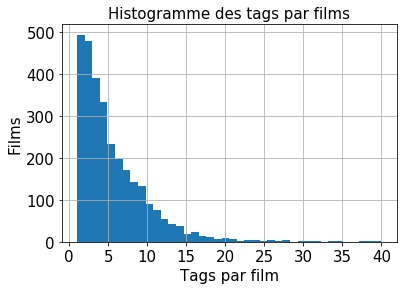

In [23]:
hists = tags_scores_high.groupby("mid").count().hist(bins=40, column="tid", xlabelsize=15, ylabelsize=15)
hists[0][0].set_ylabel("Films", size=15)
hists[0][0].set_xlabel("Tags par film", size=15)
hists[0][0].set_title("Histogramme des tags par films", size=15);

Sur cet histogramme chaque barre verticale indique le nombre de films (y-axis) associé à un nombre de *tags*. Par exemple, il y a un peu moins de 500 films qui ont reçu une seule 1 *tag*. Un film en a reçu presque 40.

**Question 1:**
Quel est le film ayant reçu le plus de *tags* (celui avec prêt de 40)? Bonus: pouvez-vous trouver les 5 films ayant reçu le plus de tags?

**Réponse:** Ci-dessous.

In [24]:
mh = tags_scores_high.groupby("mid").count()
mname = movies_pd.loc[movies_pd['mid'] == mh.tid.idxmax()].mName.to_string()
print(f'Le film le plus populaire est "{mname.to}" et il a {mh.tid.max()} tags.')

AttributeError: 'str' object has no attribute 'to'

Les prochaines étapes créent un ensemble de données pour l'apprentissage supervisé. Rappelons-nous que nous voulons arriver à prédire les notes que des utilisateurs donneraient à un film à partir de l'utilisateur, du film, ainsi que des attributs des deux.

In [ ]:
# Joindre les utilisateurs, les notes et les tags.
data_pd = pd.merge(users_pd, ratings_pd, how='inner', on='uid')
data_pd = pd.merge(data_pd, tags_per_movie, how='inner', on='mid')

Pour ce tutoriel, nous utiliserons qu'une fraction des données disponibles pour s'assurer que nous puissions estimer les modèles rapidement (en quelques minutes).

In [ ]:
# on mélange les données et l'on garde 2% de toutes les notes
# (nous n'utilisons qu'un petit sous ensemble des données pour des raisons computationelles)
data_pd = data_pd.sample(frac=0.02, random_state=1234)
print(data_pd.shape)

Notre jeu de données final à la taille suivante

In [ ]:
print('Statistiques descriptives de notre jeu de donées.')
print('\t- %d films'   % data_pd['mid'].nunique())
print('\t- %d utilisateurs'   % data_pd['uid'].nunique())
print('\t- %d notes' % data_pd.shape[0])

On note que nous avons plusieurs variables catégorielles (p.ex., sexe, l'emploi, le zip, mid). Comme dans le cas des *tags* nous encoderons ces catégorielles avec des variables dummy.

In [ ]:
print(data_pd.shape)
display(data_pd[:10])

In [ ]:
cols = ['gender','occupation','zip','mid','uid']
data_pd_dum = pd.get_dummies(data_pd, columns=cols)
print(data_pd_dum.shape)
display(data_pd_dum.head(10))

Nous avons choisi d'utiliser pandas pour transformer les variables catégorielles, nous aurions aussi pu utiliser `scikit-learn`. Le module `preprocessing` est introduit ici [here](https://scikit-learn.org/stable/modules/preprocessing.html). Je vous conseille la section sur les [Categorical features](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-categorical-features).


Nous sommes prêts (finalement!) pour construire notre premier jeu de données complet. Pour démarrer, nous utiliserons qu'un sous ensemble des attributs disponibles et notamment nous n'utiliserons pas les *tags*. 

Ci-dessous, nous allons aussi séparer notre jeu de données en un ensemble d'entraînement et un de test en utilisant la fonction `train_test_split` de `scikit-learn`. 

In [ ]:
attributes = "mid_*|uid_*|gender_*|age|zip_*|occupation_*"
X = data_pd_dum.filter(regex=('('+attributes+')')) 
print(X.shape)

rating = data_pd_dum['rating']
print(rating.shape)

# Diviser en Train/Test
# On garde 20% des données pour l'ensemble de test.
X_train, X_test, y_train, y_test = train_test_split(
    X, rating, test_size=0.2, random_state=1234, shuffle=False)

*Particularité des systèmes de recommandations:* nous avons divisé les données sans égard aux utilisateurs et aux items. En d'autres mots, les utilisateurs les plus actifs ainsi que les films les plus populaires (en moyenne) seront plus représentés dans les données non observées. Ce n'est pas nécessairement un problème, mais nous pourrions désirer être plus équitables. Dans ce cas, on pourrait diviser indépendamment les données de chaque utilisateur, et s'assurer par exemple que l'ensemble non observé contient le même nombre de données pour chaque utilisateur (ou chaque film).

*Particularité des systèmes de recommandations #2:* dans un cas réel, il aurait sans doute été souhaitable de diviser les notes en fonction du temps. Les notes avant une date précise pour l'ensemble d'entraînement et les autres pour l'ensemble de test.

In [ ]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

<a id="modelling"></a>
# Section 2: Modélisation 

Les notes ou *ratings* ([échelle de Likert](https://fr.wikipedia.org/wiki/%C3%89chelle_de_Likert)) sont des quantités ordinales. Par contre, pour faciliter la modélisation, nous les traiterons comme des valeurs réelles (nous discuterons de ces questions à la semaine 11). Nous mesurerons donc l'erreur (la fonction de perte) carrée moyenne:

$$ \text{MSE}(f(x),y) := \frac{1}{n} \sum_{i=0}^n (f(x_i) - y_i)^2$$ 

La MSE est la distance moyenne entre la prédiction ($f(x_i)$) et l'étiquette ($y_i$). La fonction MSE retourne une quantité non négative et le modèle parfait a une MSE de $0$. Si le Modèle #1 a une plus petite MSE que le Modèle #2, alors le Modèle 1 est meilleur selon cette mesure.

*Entraînement/Test:* rappelez vous que bien que nous estimions les paramètres du modèle à partir de l'ensemble **d'entraînement**, nous évaluons la qualité du modèle à partir des données de **test**.

### 2.1 Un premier modèle: prédire la moyenne

Il est souvent pratique d'obtenir un point de comparaison en utilisant une méthode très simple. 

Notre méthode étalon sera un modèle qui prédit la moyenne des notes d'entraînements. C'est donc un modèle constant qui ne prend pas en compte les attributs (des utilisateurs ou des films): 

$$ 
y_{ui} = \text{moyenne globale}
$$

*Particularité des systèmes de recommandations:* nous pourrions sand doute obtenir un modèle un peu plus performant en prédisant, pour chaque utilisateur la moyenne de ses notes (ou de manière équivalente pour les items) plutôt que la moyenne globale des notes.

In [ ]:
# Quantifier l'erreur de prédiction du modèle étalon

print("Modèle constant")

print("\tErreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, 
                           np.full_like(y_train, y_train.mean())))
print("\tErreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, 
                           np.full_like(y_test, y_train.mean())))

Les erreurs d'entraînement et de test sont, dans ce cas, très proches (la différence n'est peut-être pas significative statistiquement). Notre modèle est très simple (en apprentissage automatique on dirait qu'il a sans doute un biais élevé) et on n'imaginerait donc pas que sa performance fluctue énormément d'un ensemble de test à un autre (petite variance).

Cette erreur de test indique qu'en moyenne nos prédictions sont à 1.3 unité ($sqrt{1.6}$) de la véritable note. Ça indique donc que nous ne devrions pas être trop surpris que le modèle prédise une note sous 4 pour un film que nous aurions noté comme un 5. Cela dit, cette valeur reste quelque peu abstraite (est-ce un bon modèle ou non?) au moins jusqu'à ce qu'on la compare à la performance d'autres modèles.

### 2.2 Régression Linéaire

Pour ce second modèle, nous utiliserons un modèle de régression linéaire des notes à partir des attributs des utilisateurs. Nous utiliserons le sexe des utilisateurs, leur âge, leur code postal et leur emploi. Nous estimons ce modèle
$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$ 

$\theta_{1:6}$ sont les paramètres, $\text{gender}_u$ est le sexe de l'utilisateur $u$, nous utilisons une notation similaire pour les autres attributs. Aussi, $x_{\text{uid}_u}$ est l'identité de l'utilisateur, c'est similaire pour $x_{\text{mid}_i}$ et les films.

Veuillez noter que quelques-unes de ces variables sont catégorielles alors elles sont en fait encodées par un vecteur de paramètres. Par exemple, zip est une variable catégorielle avec 100 valeurs possibles, donc $\theta_{\text{zip}}$ a 100 dimensions. 

Pour entrainer le modèle, il faut minimiser l'erreur d'entrainement (train MSE), c'est exactement ce que propose la classe `LinearRegression`. (C'est un problème de [moindre carrés](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) et il existe donc une solution en forme fermée.)

In [ ]:
# Créer l'objet de régression linéaire
reg = linear_model.LinearRegression()

# Entraîner le modèle à partir des données d'entraiînement
reg.fit(X_train, y_train)

print("Number of parameters: ", reg.coef_.shape[0]+1)

Avant de regarder les résultats. Pensez-vous que le modèle que nous venons d'entraîner généralisera bien ou non? 

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = reg.predict(X_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = reg.predict(X_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Notez que l'erreur d'entraînement est $<<$ que l'erreur de test ($<<$ veut dire « bien plus petit »). C'est évidemment un problème de surentraînement (*overfitting*). C'est-à-dire que le modèle a appris l'ensemble d'entraînement et ne peut donc pas généraliser à de nouvelles données (c'est un modèle à faible biais et variance élevée). 

Comme nous en avons discuté en classe, il existe plusieurs méthodes pour limiter voir empêcher le surentraînement. Pour l'instant, nous régulariserons le modèle pour limiter le surentraînement. L'idée est que nous ajouterons à la fonction de perte un terme pour empêcher les paramètres de prendre des valeurs trop élevées, ce qui à priori, devrait aider le modèle à mieux généraliser (notamment parce que la fonction sera plus lisse). Cette pénalité ou régularisateur est ajouter à la fonction de perte qui devient:s
$$  \text{loss} := \text{MSE} + \alpha \sum_i ||\theta_i||_2^2 $$

Au lieu de $ \text{loss} := \text{MSE} $. Notez: 
- $||\cdot||_2$ est la norme 2. C'est-à-dire la racine carrée de la somme des éléments au carré.
- $\alpha$ est un hyperparamètre qui fixe l'importance du régularisateur (si $\alpha=0$ la régularisateur est nul et si $\alpha=\infty$ tous les paramètres régularisés doivent être exactement égales à 0). Un hyperparamètre n'est pas appris pendant l'entraînement, mais fixé à priori (ici, apprendre $\alpha$ en même temps que $\theta$ mènerait à estimer $\alpha=0$). \[Dans les notes de cours, j'ai utilisé le symbole $\lambda$ pour cet hyperparamètre.\]

Pendant l'entraînement, le modèle doit trouver un compromis entre la performance (MSE) et la complexité du modèle ($\theta$ élevés). 

Notez, qu'il y a différents noms pour ce régularisateur par exemple *weight decay*, *L2-regularization* et régression *ridge*. Scikit-learn utilise la classe `Ridge` dans la libraire `linear_model` pour estimer un modèle de régression linéaire régularisé.

In [ ]:
# Créer le modèle de régression linéaire régularisé
regr = linear_model.Ridge(alpha=10)

# Entraîner le modèle avec l'ensemble d'entraînement
start = time.time()
regr.fit(X_train, y_train)
fit_time = time.time() - start

print("Temps d'apprentissage: %.2f seconds" % fit_time)

print("Nombre de paramètres:", regr.coef_.shape[0]+1)

**Question 3:** Pourquoi le modèle a 7,184 paramètres? En d'autres mots, à quoi correspondent ces paramètres?

**Indice:** N'oubliez pas le terme de biais (intercepte)

**Réponse:** Il y a un intercepte et 7183 attributs: 
- 2 sexe, 
- 100 code postal,
- 2403 mid, 
- 46562 uid,
- 1 age, 
- 21 emploi.

In [ ]:
# Obtenir les prédictions sur l'ensemble d'entraînement
y_train_pred = regr.predict(X_train)

print("Erreur au carré moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions sur l'ensemble de test
y_test_pred = regr.predict(X_test)

print("Erreur au carré moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))

Par rapport au modèle sans régularisation, nous observons que le modèle avec $\alpha=10$ obtient des erreurs  beaucoup plus proches l'une de l'autre (il y a donc moins de surentraînement). D'autres valeurs de $\alpha$ devrait aussi affecter la capacité à généraliser du modèle.


**Question 4:** Comment trouver la meilleure valeur pour $\alpha$ étant donné un modèle et un jeu de données?

**Indice:** Regardez [RidgeCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV), une version du modèle ridge avec de la validation croisée.

**Answer:** Voir plus bas. 

In [ ]:
# Créer l'objet de régression linéaire
regRCV = linear_model.RidgeCV(alphas=[1, 10, 100])

# Entraîner le modèle à partir de l'ensemble d'entraînement
regRCV.fit(X_train, y_train)

print("Nombre de paramètres: %d, estimated alpha: %d" % (regRCV.coef_.shape[0], regRCV.alpha_))

Dans ce cas $\alpha=10$ offre la meilleure performance sur un ensemble (interne) de validation comparativement aux autres valeurs de $\alpha$ proposées.

Remarque technique: puisque l'estimation des paramètres est souvent effectuée en prenant une transformation logarithmique de l'objectif, il est normal d'essayer des valeurs de $\alpha$ qui correspondent à des puissances de 10.

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = regRCV.predict(X_train)

print("Erreur carrée moyenne d'entraînement: %.3f"
      % mean_squared_error(y_train, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = regRCV.predict(X_test)

print("Erreur carrée moyenne de test: %.3f"
      % mean_squared_error(y_test, y_test_pred))

L'avantage de la validation croisée (par exemple `RidgeCV`) est clair. Cette méthode cherche automatiquement la meilleure valeur d'un hyper paramètre (ici $\alpha$) à partir d'un ensemble possible (ici:  $\{ 1, 10, 100 \}$). 

La validation croisée devrait toujours être utilisée pour trouver de bons hyper paramètres (surtout pour les modèles non linéaires, différents hyper paramètres peuvent donner des résultats bien différents). Il est aussi possible que vous deviez implémenter cette procédure vous-même. Dans ce cas, il est alors nécessaire d'utiliser (explicitement) un ensemble de validation (que vous diviser à partir de votre ensemble d'entraînement). Dans `sklearn` vous pouvez utiliser la fonction `train_test_split`. La taille de l'ensemble de validation est souvent la même que la taille de l'ensemble de test.

Très important, **ne sélectionnez jamais vos hyperparamèetres en fonction de votre performance sur l'ensemble de test**, ceci vous donnera des résultats trop optimistes (donc une erreur plus basse) puisque vous utilisez en fait votre ensemble de test pour entraîner votre modèle. L'ensemble de test sert à obtenir une estimation non biaisée de l'erreur qui peut donc être utilisée pour comparer différents modèles. 

***

Maintenant que nous avons un modèle entraîné, nous pouvons explorer ses prédictions

In [ ]:
# helpfer function to return non-zero columns
def non_zero(row, columns):
    col_name = list(columns[~(row == 0)])[0]
    #r = re.sub('mid_','',l)
    return col_name

In [ ]:
# obtenir le nombre de notes par film (popularité)
mids = X_test.filter(regex=('mid_*'))
y_mid_cols = mids.apply(lambda x: non_zero(x, mids.columns), axis=1)
movie_popularity = X_train.filter(regex=('mid_*')).sum(axis=0)[ y_mid_cols ]

# obtenir le nombre de notes par utilisateur (niveau d'activité d'un utilisateur)
uids = X_test.filter(regex=('uid_*'))
y_uid_cols = uids.apply(lambda x: non_zero(x, uids.columns), axis=1)
user_activity = X_train.filter(regex=('uid_*')).sum(axis=0)[ y_uid_cols ]

err = (y_test_pred-y_test)

In [ ]:
# simplement tracer un sous-ensemble pour l'interprétabilité
subn = 500 
fig, (ax0, ax1) = plt.subplots(ncols=2)
fig.set_figwidth(15)
ax0.scatter(movie_popularity[:subn], err[:subn])
ax0.set_ylabel('Prediction error')
ax0.set_xlabel('Movie Popularity')

ax1.scatter(user_activity[:subn], err[:subn])
ax1.set_ylabel('Prediction error')
ax1.set_xlabel('User Activity');

Ces deux figures montrent l'erreur des prédictions (sur un sous-ensemble) de test versus la popularité des films (axe des x à gauche) et le niveau d'activité d'un utilisateur (axe des x à droite). Notez que:

- Cette distribution empirique semble symétrique, donc il y n'y a pas de biais particulier à des prédictions plus élevées ou plus basses.
- L'erreur de prédiction semble montrer que les films et les utilisateurs ayant plus de données ont aussi une plus petite erreur de prédiction (c.-à-d., les données forment un "triangle" pointant vers la droite, ceci devient beaucoup plus évident quand nous entraînons le modèle avec plus de données). Ce résultat tombe sous le sens, le plus de données le modèle observe sur un film, le plus précis le modèle devrait être pour ce film (son estimation de $\theta_{\text{mid}}$ sera plus précise). Cet effet est peut-être aussi renforcé par le fait que nous ayons divisé les données aléatoirement en entraînement et test. Il devient plus avantageux pour le modèle de correctement modéliser les films et les utilisateurs ayant le plus de données.

### 2.3 Régression linéaire avec les tags comme attribut.

Nous utilisons encore une fois un modèle de régression linéaire, mais nous y ajoutons les tags des films:

$$
f(x_{ui}) = \theta_\text{gender} x_{\text{gender}_u} + \theta_{\text{age}} x_{\text{age}_u} + \theta_\text{zip} x_{\text{zip}_u} + \theta_\text{occupation} x_{\text{occupation}_u} + \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i} \mathbf{+ x_{\text{tags}_i}\boldsymbol\theta_\text{tags}}
$$ 

Le dernier terme à droite (en gras) est ajouté par rapport au modèle précédent.

**Question 5:** Comment pensez-vous que ce modèle performera par rapport au modèle précédent (Section 2.2.)? Pouvez-vous dire quelque chose de formel par rapport à sa performance?

**Indice:** Un des modèles est une généralisation de l'autre. 

**Réponse:** 
- Le modèle 2.2 est un cas particulier du modèle 2.3. Quand $\theta_\text{tags}=0$ les deux modèles sont équivalents. 
- Le modèle 2.3 pourrait donc atteindre une meilleure performance que le modèle 2.2. C'est aussi possible, que ces attributs en plus mènent à un modèle qui puisse plus facilement surentraîner. 
- Puisque le modèle 2.3 pourrait apprendre que $\theta_\text{tags}=0$, il ne devrait jamais performer moins bien que le modèle 2.2.

In [ ]:
# Nous construisons maintenant un jeu de données en y ajoutant les tags (tid_*)
X_tags = data_pd_dum.filter(regex=('('+attributes+"|tid_*"+')'))
print(X_tags.shape)

# Divisons l'échantillon en Entraînement/Test.
# Nous utilisons la machine racine (seed) qu'avant pour s'assurer que la division sera la même
X_train_tags, X_test_tags, y_train_tags, y_test_tags = train_test_split(
    X_tags, rating, test_size=0.2, random_state=1234, shuffle=False)
print(X_train_tags.shape)

In [ ]:
# Créer l'oject de régression linéaire
regr_tags = linear_model.Ridge(alpha=10)

# Entraîner le modèle sur l'ensemble d'entraînement
start = time.time()
regr_tags.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("Temps de l'apprentissage du modèle: %.2f seconds" % fit_time)
print("Nombre de paramètres:", regr_tags.coef_.shape[0]+1)

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = regr_tags.predict(X_train_tags)

print("Erreur au carré moyenne d'entraînement: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = regr_tags.predict(X_test_tags)

print("Erreur au carré moyenne de test: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))

À noter: l'erreur de test est de 0.99 pour ce modèle (2.3) comparé à une erreur MSE de test de 1.03 pour le modèle 2.2. Les tags semblent offrir une performance légèrement supérieure, mais elles ont aussi besoin d'un modèle d'une plus grande taille (968 paramètres en plus à estimer) ce qui prend environ 30% en plus à optimiser. Évidemment, ce n'est pas une comparaison exacte et elle dépend de votre ordinateur. Ceci étant dit, il semble quand même que l'algorithme d'estimation n'est pas linéaire (c.-à-d., augmenter le nombre de paramètres par 10%, augmente la durée de l'estimation par 30%).

***

### 2.4 Apprendre un modèle non linéaire

Pour l'instant nous avons étudié l'effet d'utiliser différents attributs sur un modèle linéaire. Il semble qu'ajouter des attributs aide à obtenir une meilleure performance de généralisation.

Maintenant nous explorerons un modèle non linéaire, un réseau de neurones à une couche cachée (les réseaux de neurones seront le thème des deux prochaines semaines). La tâche est les données ne changent pas, seulement le modèle.

**Le b.a.-ba des réseaux de neurones:** 
- Un réseau de neurones est constitué de neurones interconnectés. Chaque neurone n'effectue que quelques calculs simples. 
- Dans un réseau *feed-forward*, les neurones sont organisés dans des ensembles appelés couches (*layers*). 
 - Les neurones de chaque couche obtiennent leurs entrées des neurones de la couche précédente. Les neurones d'une couche envoient donc le résultat de leur calcul à la couche d'après. 
 - La première couche est appelée couche entrante (*input layer*) elle utilise directement les données et les passent à la seconde couche. La dernière couche est celle de sortie (*output layer*) elle calcule les prédictions finales $\hat{y}$. 
 - Les couches entre la couche d'entrée et de sortie sont appelées les couches cachées (*hidden layers*). Chaque neurone des couches cachées est un modèle linéaire suivit d'une fonction d'activation non linéaire (*activation function*): $f(x) = \sum_i x_i \theta_i$. 
  - Le nombre de neurones des couches d'entrée et de sortie est fixé par les données (le nombre des attributs et le nombre de prédictions par exemple). 
  - Le nombre de neurones de chaque couche cachée est un hyper paramètre. Un autre hyper paramètre est le nombre de couches cachées.

Mathématiquement, pour une tâche de régression (avec une seule prédiction par exemple), un réseau de neurones à une couche cachée est: 
$$ 
f(x) = f_\text{o} ( \sum_{j=0}^{|\text{hidden n.}|} \theta'_{j} f_\text{h}( \sum_{i=0}^{|p|}\theta_{ij} x_i ) ) 
$$ 
avec
- $\theta_{ij}$ les paramètres des entrées $i$ et neurone $j$ d'une couche cachée.
- $f_h$ est la fonction d'activation d'une couche cachée
- $\theta'_{j}$ sont les paramètres qui connectent le neurone $j$ de la couche cachée à la couche de sortie.
- $f_o$ est la fonction d'activation de la couche de sortie


Il peut être plus intuitif de visualiser l'architecture d'une réseau de neurones en dessinant les neurones comme étant de noeuds et les connections comme des arrêtes dans un graphe:

In [ ]:
# un réseau de neurones à une couche cachée où l'entrée à 10 dimensions (p=10) et la sortie une seule dimension
input_dims = 10 # p 
# nombre de neurones cachées pour chaque couche cachée (pour ajouter une couche il faut ajouter une dimension)
hidden_layers_size = [4] 
output_dims = 1 # nombre de sorties

network = DrawNN( [input_dims] + hidden_layers_size + [output_dims] )
network.draw()

In [ ]:
# Créer un réseau de neuronnes
regr_nn = neural_network.MLPRegressor(alpha=0.1, # l2-regularization (weight decay)
                                      hidden_layer_sizes=tuple(hidden_layers_size),
                                      early_stopping=True, # stop if validation performance decreases
                                      verbose=True,
                                      random_state=1234)

# Estimer les paramètres du réseau sur nos données

#normalize data
start = time.time()
regr_nn.fit(X_train_tags, y_train_tags)
fit_time = time.time() - start

print("Temps d'apprentissage du modèle: %.2f seconds" % fit_time)
print("Nombre de paramètres:", reduce(lambda x,y: x+y, 
                                       list(map(lambda x: x.size, regr_nn.coefs_+regr_nn.intercepts_)) ))

Comme pour les autres modèles, nous pouvons régulariser les paramètres du réseau pour éviter le surentrainement:
- Nous utilisons la même taille du régularisateur L2 pour tous les paramètres. La taille du régularisateur est donnée par $\alpha$. 
- En plus, nous utilisons un second régularisateur qui se nomme `early-stopping`. L'apprentissage des paramètres dans un réseau de neurones est une procédure littérature en utilisant une méthode appelée descente de gradient (par rapport à la régression linéaire, il n'existe pas de solution analytique permettant de trouver les paramètres optimaux en fonction de la fonction d'objectif). Le *Early stopping* évalue simplement une erreur de validation après chaque itération d'entraînement. La procédure stoppe l'apprentissage une fois que l'erreur de validation arrête de progresser. Ceci peut évidemment arriver avant que l'erreur d'entraînement converge. Si ce n'est pas le cas, ce régularisateur n'a aucun effet sur l'apprentissage. Dans `scikit-learn`, la classe `MLPRegressor` avec `early_stopping=True` divise automatiquement l'ensemble d'entraînement en deux (validation et entraînement). Le désavantage évidemment est qu'il reste un tout petit moins de données pour s'entraîner.




**Question 6:** Pourquoi dans `sklearn` ce modèle permet-il de fixer une racine (c.-à-d., `random_state`) alors que le modèle de régression linéaire ne le permet pas? 

**Réponse:** La régression linéaire n'a qu'une seule solution (c-à-d., peu importe l'initialisation des paramètres , la solution sera la même). Ce n'est en général pas le cas pour les réseaux de neurones. En pratique, une bonne initialisation peut faire une grande différence sur la généralisation du modèle (il existe d'ailleurs beaucoup d'heuristiques d'initialisation pour tenter d'obtenir des solutions qui généralisent le mieux possible).

In [ ]:
# Obtenir les prédictions d'entraînement
y_train_pred = regr_nn.predict(X_train_tags)
#y_train_pred = regr_nn.predict(scaler.transform(X_train_tags))


print("Erreur au carré moyenne d'entraînement: %.4f"
      % mean_squared_error(y_train_tags, y_train_pred))

# Obtenir les prédictions de test
y_test_pred = regr_nn.predict(X_test_tags)
#y_test_pred = regr_nn.predict(scaler.transform(X_test_tags))

print("Erreur au carré moyenne de test: %.4f"
      % mean_squared_error(y_test_tags, y_test_pred))
#Train Mean squared error: 0.6623
#Test Mean squared error: 1.0465

Voici notre tableau des résultats

| Modèle        | MSE de test           |
| ------------- |:-------------:| 
| 2.2 (Reg. linéaire avec attributs)     | 1.031 | 0.8650  |
| 2.3 (2.2 + *tags* des films)     | 0.991 | 0.8571 |
| 2.4 (Réseau de neurones avec les attributs de 2.3) | 1.029 | 0.8650 | 

Même si les réseaux de neurones sont très puissants (leur capacité est haute), sur cette tâche le réseau de neurones entraîné n'améliore pas la performance d'un modèle de régression plus simple. Ce n'est évidemment pas indicatif de la performance de tous les réseaux de neurones (il est possible qu'une réseau de neurones un peu différents obtiennent de meilleurs résultats). 

<a id="concluding-remarks"></a>
### Section 3. Conclusions

Le but de ce tutoriel était de vous introduire à l'apprentissage automatique de manière très pratique et de complémenter le cours. Nous nous pencherons évidemment en détail sur les réseaux de neurones dans les semaines à venir.

Avant de terminer: 

#### Apprentissage automatique

Comme vous avez pu le constater, l'apprentissage machine pratique est très empirique. Une fois que vous avez des données dans un format correct, il est typique de les utiliser pour estimer et comparer différents modèles. Vous pouvez tenter de comprendre les avantages/désavantages de ces modèles dans votre contexte. C'est aussi une bonne manière de mieux comprendre vos données. En pratique, c'est souvent un aspect essentiel que nous n'avons pas énormément abordé dans ce tutoriel (au profit d'une meilleure exploration des modèles).


#### Scikit-learn
`scikit-learn` est une libraire de ML très pratique et puissant. C'est une boîte à outils de modèles ainsi que de routines pour prétraiter vos données. Elle offre une interface à une grande variété de modèles, elle reste activement développée et en général c'est une excellente plateforme. C'est aussi une libraire ouverte (*open source*) et gratuite à utiliser. 

Sélection de modèles: choisir le meilleur (ou même un bon) modèle pour une tâche particulière n'est pas une mince affaire. [Cette page](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) offre des conseils pour la sélection de modèles disponibles sur `scikit-learn`. N'oubliez pas qu'en pratique, la performance de test n'est souvent qu'une seule mesure parmi d'autres (qui peuvent inclure, par exemple, le temps d'estimation du modèle, le taux de faux positif ou faux négatifs, etc.)

Bien que très versatile, `scikit-learn` n'est pas utilisable pour tout. Par exemple, cette libraire n'offre que très peu de réseaux de neurones modernes. Ce n'est pas non plus, la plateforme idéale pour développer de nouveaux modèles.

#### D'autres libraires

La qualité des logiciels disponibles a largement contribué à la popularité de l'apprentissage automatique dans les dernières années. Les logiciels modernes automatisent une série de tâches qui permettent aux programmeurs d'être plus efficaces. `scikit-learn` est un outil très populaire, mais il existe évidemment d'autres librairies de bonne qualité (tant pour utiliser des modèles existants que pour développer de nouveaux modèles). Il peut évidemment être pratique et tentant d'apprendre plusieurs de ces librairies. À mon avis, c'est encore plus important d'avoir une compréhension des fondamentaux de l'apprentissage automatique d'autant plus que les librairies changent souvent très rapidement. 

#### Matière à réflexion
 - Dans nos modèles nous avons pris comme hypothèse que les notes sont les variables dépendantes (y) et que nous avions accès à des attributs des utilisateurs et des items. Imaginone une tâche où nous n'aurions pas accès à des attributs, ou bien à un cas où les attributs ne seraient pas informatifs des notes. Dans ce cas, le modèle de régression linéaire deviendrait: 
 
$$
f(x_{ui}) = \theta_\text{uid} x_{\text{uid}_u} + \theta_{\text{mid}} x_{\text{mid}_i}
$$ 
 

- **Question 7:** Quel est le problème avec ce dernier modèle? Je vous suggère d'y réfléchir un peu avant de lire la réponse. 

- **Réponse possible:** (il y en a d'autres)
    - Il n'y aucune interaction entre les utilisateurs et les items. Prenons l'exemple d'un utilisateur, cet utilisateur contribuera un coefficient $\theta_{\text{uid}_u}$ fix peu importe le film. Ce modèle ne modélisera que la note moyenne de l'utilisateur (idem pour les paramètres des films qui modéliseront leur popularité). L'effet sera que les recommandations seront les mêmes pour tous les utilisateurs.
     - A la place, vous pourriez imaginer introduire une interaction entre les utilisateurs et les items. P. ex., 
     
     $$x_{\text{uid}_u} * x_{\text{mid}_i} * \theta_{\text{uid}_u} * \theta_{\text{mid}_i}.$$

       Ce genre d'interaction arrivera de manière naturelle dans les réseaux de neurones (je vous laisse vous convaincre). Pendant la semaine 11 nous parlerons aussi d'un modèle nommé [factorisation de matrice](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf) qui utilise cette intuition.

- Comme nous le verrons à la semaine 11 (sur les systèmes de recommandation), il existe plusieurs modèles qui utilisent les notes en entrée **et** en sortie. Par exemple, on pourrait directement utiliser les notes historiques d'un utilisateur pour prédire ses notes futures  (pour ce faire on pourrait utiliser un auto-encodeur).

## Références


Scikit-learn (en anglais)
- [Documentation](https://scikit-learn.org/stable/documentation.html)
- [Tutoriels](https://scikit-learn.org/stable/tutorial/index.html)
- [Aide à la sélection de modèles](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)